In [9]:
from langgraph.graph import StateGraph,START, END
from typing import TypedDict, Annotated
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field
from langchain_core.prompts import PromptTemplate
import operator

load_dotenv()

model = ChatOpenAI(model='gpt-4o-mini')

In [10]:
class Feedback(BaseModel):
    textual_feedback: str = Field(..., description="Feedback on the essay")
    rating: int = Field(..., ge=1, le=10, description="Rating from 1 to 10")

structured_model = model.with_structured_output(Feedback)

essay_evaluation_prompt = PromptTemplate(
    input_variables=["evaluation_type", "essay"],
    template=(
        "You are an expert writing evaluator.\n\n"
        "Evaluation Type:\n"
        "{evaluation_type}\n\n"
        "Essay:\n"
        "{essay}\n\n"
        "Instructions:\n"
        "- Evaluate the essay strictly according to the evaluation type provided.\n"
        "- Give short textual feedback.\n"
        "- Provide an overall rating from 1 to 10, where:\n"
        "  1 = very poor\n"
        "  10 = excellent"
    )
)

essay = """ Cricket is more than a sport in many countries, making political influence almost inevitable. International relations often affect cricketing ties, leading to canceled tours or matches at neutral venues due to diplomatic tensions. Such decisions impact players and fans alike.

Politics also plays a role in cricket administration, where government influence over boards can result in favoritism and lack of transparency. At the same time, cricket is frequently used as a tool for national pride and soft power, with victories and tournaments carrying political significance.

Despite these challenges, cricket has sometimes helped ease political tensions by fostering dialogue and unity. Overall, while politics can support cricket through resources and visibility, excessive interference threatens fairness. Maintaining transparency and merit is essential to preserve the spirit of the game."""

In [11]:
class UpscState(TypedDict):
    essay: str
    depth_of_analysis_feedback: str
    chain_of_thoughts_feedback: str
    coherence_feedback: str
    overall_feedback: str
    input_scores: Annotated[list[int], operator.add]
    average_score: float

In [12]:
def get_depth_of_analysis_feedback(state: UpscState) -> dict:
    prompt = essay_evaluation_prompt.format_prompt(
        evaluation_type="Depth of Analysis",
        essay=state['essay']
    )
    result = structured_model.invoke(prompt.to_string())
    return {'depth_of_analysis_feedback': result.textual_feedback, 'input_scores': [result.rating]}

def get_chain_of_thoughts_feedback(state: UpscState) -> dict:
    prompt = essay_evaluation_prompt.format_prompt(
        evaluation_type="Chain of Thoughts",
        essay=state['essay']
    )
    result = structured_model.invoke(prompt.to_string())
    return {'chain_of_thoughts_feedback': result.textual_feedback, 'input_scores': [result.rating]}

def get_coherence_feedback(state: UpscState) -> dict:
    prompt = essay_evaluation_prompt.format_prompt(
        evaluation_type="Coherence",
        essay=state['essay']
    )
    result = structured_model.invoke(prompt.to_string())
    return {'coherence_feedback': result.textual_feedback, 'input_scores': [result.rating]}

def get_overall_feedback(state: UpscState) -> dict:
    prompt = (
        "You are an expert writing evaluator. Based on the following three feedback evaluations, "
        "provide a concise overall feedback summary.\n\n"
        f"Depth of Analysis Feedback:\n{state['depth_of_analysis_feedback']}\n\n"
        f"Chain of Thoughts Feedback:\n{state['chain_of_thoughts_feedback']}\n\n"
        f"Coherence Feedback:\n{state['coherence_feedback']}\n\n"
        "Provide a short overall summary combining all three evaluations."
    )
    result = model.invoke(prompt)
    scores = state['input_scores']
    average = sum(scores) / len(scores) if scores else 0.0
    return {'overall_feedback': result.content, 'average_score': average}

In [13]:
graph = StateGraph(UpscState)

graph.add_node("depth_of_analysis", get_depth_of_analysis_feedback)
graph.add_node("chain_of_thoughts", get_chain_of_thoughts_feedback)
graph.add_node("coherence", get_coherence_feedback)
graph.add_node("overall_feedback", get_overall_feedback)

graph.add_edge(START, "depth_of_analysis")
graph.add_edge(START, "chain_of_thoughts")
graph.add_edge(START, "coherence")
graph.add_edge("depth_of_analysis", "overall_feedback")
graph.add_edge("chain_of_thoughts", "overall_feedback")
graph.add_edge("coherence", "overall_feedback")
graph.add_edge("overall_feedback", END)

compiled_graph = graph.compile()

result = compiled_graph.invoke({"essay": essay})
print("############# Overall Feedback #############")
print(result['overall_feedback'])
print("############# Average Score #############")
print(result['average_score'])

############# Overall Feedback #############
Overall, the essay presents a coherent and insightful exploration of the relationship between cricket and politics, effectively identifying key themes and maintaining a logical flow. However, it lacks depth and clarity, primarily due to the absence of specific examples and case studies that could illustrate the dynamics discussed. While the balance between positive and negative influences is commendable, deeper analysis of political interference and a stronger conclusion would enhance the argument. To strengthen the essay, it is recommended to elaborate on individual points and establish clearer connections between them, while incorporating supporting evidence to enrich the overall analysis.
############# Average Score #############
6.666666666666667


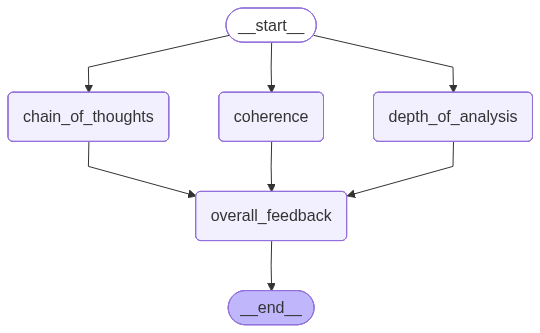

In [14]:
from IPython.display import Image
Image(compiled_graph.get_graph().draw_mermaid_png())